## Extract Balanced Flows and Interpolate the gap between the two SWOT swaths using the KaRIn and Nadir data

In [9]:
import netCDF4 as nc
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist 
import mpmath as mp
import cartopy.crs as ccrs
from math import sin, cos, sqrt, atan2, radians
import os
import cmocean 
from glob import glob
import numpy as np
import time
import mpmath as mp
from scipy.special import gamma
import matplotlib.pyplot as plt
import JWS_SWOT_toolbox as swot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Import the KaRIn and Nadir data, match the data files, and build the datasets 

Search through the data directory and import files for KaRIn and Nadir with same cycles and specified pass number

In [10]:
# Config. parameters
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/' # I'd recommend seperate the SCIENCE and CALVAL data

# min_cycle = 476
# max_cycle = 580

pass_number = 9
lat_min = 28 #32 #29
lat_max = 34 #38 #35

# return the files in the data directory for the specified pass number
# karin_files, nadir_files are sorted by cycle and contain the same cycles
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_number)

# Returns indexes for the Karin and Nadir data between lat_min and lat_max 
sample_index = 2 # some file we use to build the arrays in case the first one hsa NaNs
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims = [len(shared_cycles), track_length, track_length_nadir]
print(dims)

[95, 339, 99]


In [11]:
# Init the data classes -- (time, along_track, across_track)
karin, nadir = swot.init_swot_arrays(dims, lat_min, lat_max, pass_number)

# Load and process Karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# Load and process Nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Builds the coordinate grids -- in [m]
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

Overall SSH variance (overall_var): 0.017910151631438834
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 190
Number of Quality Masked KaRIn strips : 118
Number of High Variance strips removed : 0

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 235.84 (span: 235.84 km)
Y grid range (km): 0.00 to 687.70 (span: 687.70 km)
Track Length: 687.70 km
Swath Width: 117.92 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


2023-04-07T04:01:04.968724000


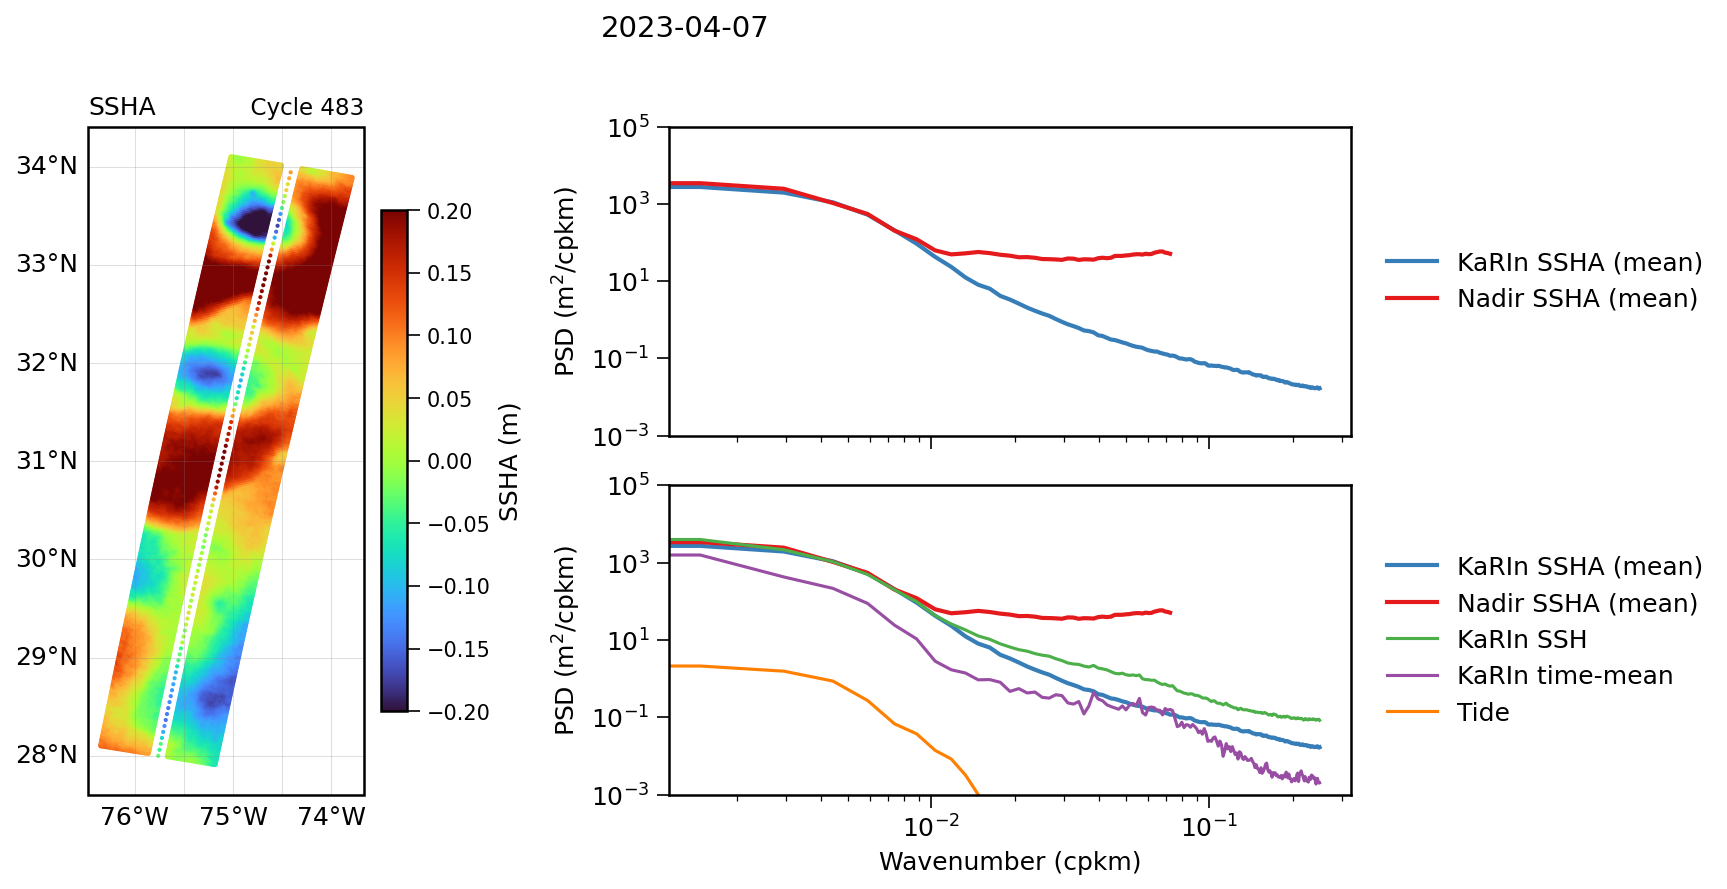

In [12]:
# --- Plot fields and spectra (fixed layout & axes) ---
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

index = 6
vmax = 0.2
vmin = -0.2
ylims = (1e-3, 1e5)

swot.set_plot_style()

# Use a single GridSpec for the whole figure
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(14, 6), dpi=150)
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.25, 1.0], height_ratios=[1.0, 1.0], figure=fig)

# -------- Map (left column spans both rows) --------
ax1 = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
cmap = cmocean.cm.deep
cmap = 'turbo'

sc = ax1.scatter(
    karin.lon[index, :, :], karin.lat[index, :, :],
    c=karin.ssha[index, :, :], s=3, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index, :], nadir.lat[index, :],
    c=nadir.ssh[index, :].flatten(), vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25, color='gray', linestyle='-',
                   xlabel_style={'size': 12}, ylabel_style={'size': 12})
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True
ax1.set_title('SSHA', loc='left')
ax1.set_title(f'\n  Cycle {shared_cycles[index]}', loc='right', fontsize=11)
cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', shrink=0.75, pad=0.02)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('SSHA (m)')

# -------- Power Spectra (right column: two stacked panels) --------
# Consistent x in cycles per km
kx_karin = karin.wavenumbers * 1e3   # cycles/km
kx_nadir = nadir.wavenumbers * 1e3   # cycles/km

# Top spectra: along-track anomalies averaged over time/samples
ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(kx_karin, karin.spec_alongtrack_av, label='KaRIn SSHA (mean)', linewidth=2)
ax2.loglog(kx_nadir, nadir.spec_alongtrack_av, label='Nadir SSHA (mean)', linewidth=2)
ax2.set_ylabel('PSD (m$^2$/cpkm)')
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
ax2.tick_params(axis='x', which='both', labelbottom=False)

# Bottom spectra: components (SSH, time-mean, filtered, tide) + references
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)

# Guard against NaNs in optional components
def _safe_loglog(ax, x, y, *args, **kwargs):
    if y is None: 
        return
    y_plot = np.asarray(y)
    if y_plot.ndim == 0: 
        return
    ax.loglog(x, y_plot, *args, **kwargs)

# KaRIn components
_safe_loglog(ax3, kx_karin, karin.spec_alongtrack_av, label='KaRIn SSHA (mean)', linewidth=2)
_safe_loglog(ax3, kx_nadir, nadir.spec_alongtrack_av, label='Nadir SSHA (mean)', linewidth=2)
_safe_loglog(ax3, kx_karin, karin.spec_ssh,           label='KaRIn SSH', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_tmean,         label='KaRIn time-mean', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_filt_tmean,    label='KaRIn time-mean (filtered)', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_tide,          label='Tide', linewidth=1.5)

ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('PSD (m$^2$/cpkm)')
ax3.set_ylim(ylims)
ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plot_dt = karin.time_cycle_dt[index]  # or nadir.time_cycle_dt[index]
print(plot_dt)
if not np.isnat(plot_dt):
    fig.suptitle(str(plot_dt)[:10], fontsize=14, y=0.98)

plt.tight_layout()
plt.show()


## 2. Extract the balanced signal

### Model balanced and unbalanced signal from KaRIn and nadir


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.6621e+03 ± 4.37e+01
lambda balanced :   2.4273e+05 ± 2.35e+03
slope balanced  :   4.4403e+00 ± 3.45e-02
Amp. noise      :   1.5485e+00 ± 1.14e-01
lambda noise    :   1.0000e+05 ± 0.00e+00
slope noise     :   1.2471e+00 ± 2.96e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 41.28305263621661 ± 1.67e+00


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (m$^2$ cpm$^{-1}$)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (m$^2$ cpm$^{-1}$)'>],
       dtype=object))

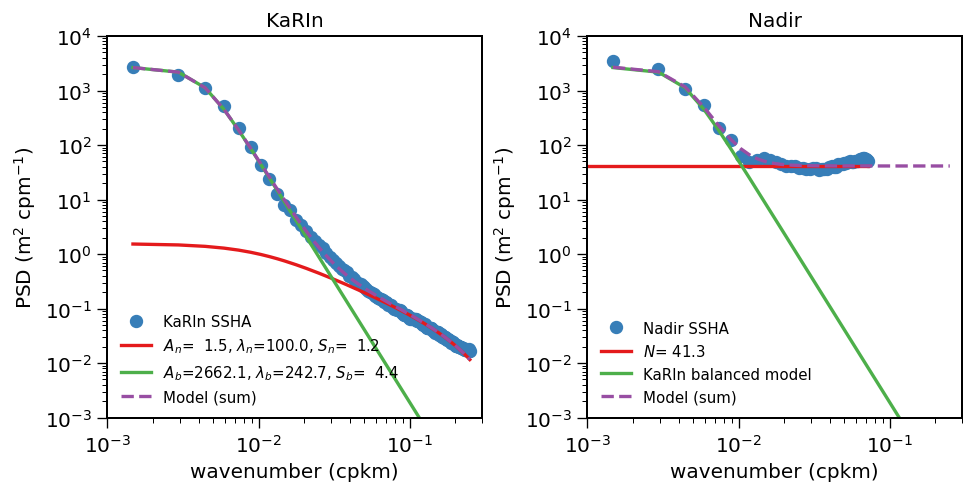

In [13]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir)

## 3. Generate Covariances 

We now generate covariance functions for our spectrum models to extract the balanced component and also interpolate the gap. 

First we will do a test reconstruction with a random signal and noise field which will have the same spectral characteristics as the SWOT spectra above.

Our target grid we extend from 60 pixels to 64 using the GPR to get input suitable for ST. 

In [14]:
# Parameters from spectral estimation above
A_b, lam_b, s_param = poptcwg_karin[0], poptcwg_karin[1], poptcwg_karin[2] # balanced params from fit
A_n, s_n, lam_n = poptcwg_karin[3], poptcwg_karin[5], 1e5 # unbalanced params from fit, we fixed lam_k to 100km in unbalanced model above
N_n = poptcwg_nadir[0] # Nadir noise

# Pull in our parameters
ny = 2*karin.swath_width
gap = karin.middle_width
delta_kx = karin.dx
delta_ky = karin.dy
delta_n = nadir.dy
nx = karin.track_length
nn = nadir.track_length 

# balanced covariance functions
S = lambda k: A_b / (1 + (lam_b * k)**s_param)
c = swot.cov(S, 5000000, 10000e3)

# unbalanced covaiance functions
cutoff = 1e3
sigma = 2 * np.pi * cutoff/np.sqrt(2*np.log(2)) 
Sk = lambda k: A_n / (1 + (lam_n * k)**2)**(s_n / 2) * np.exp(-0.5 * ((sigma**2)*(k**2))) # adds guassian taper to smallest scales
nk = swot.cov(Sk, 5000, 10000e3)
sigma = np.sqrt(N_n / (2 * delta_n))

# Observation points
xk, yk = swot.make_karin_points(karin) 
xn, yn = swot.make_nadir_points(karin, nadir)

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# Covariance matrices
C = swot.build_covariance_matrix(c, xobs, yobs)
N, Nk = swot.build_noise_matrix(nk, xk, yk, sigma, nn, nx * ny)

# Cholesky decompositions
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")

Variance from spectrum:   0.011939
Variance from covariance: 0.011939
Variance from spectrum:   0.000042
Variance from covariance: 0.000042
Calculating covariance matrices...
Calculating noise matrices...
Performing Cholesky decomposition for C...
Cholesky(C) time: 43.0400 seconds
Performing Cholesky decomposition for Nk...
Cholesky(Nk) time: 40.7808 seconds


## 5. Apply the models to the real SWOT SSH data 

In [15]:
import numpy as np
from scipy.linalg import block_diag

# --- Masks (built on the arrays we index) ---
mask_k = np.isfinite(karin.ssha[index])           
mask_n = np.isfinite(nadir.ssh[index]).ravel()    

# --- KaRIn (2D) ---
hkk = karin.ssha[index][mask_k].ravel()
xkk = karin.x_grid[mask_k].ravel()
ykk = karin.y_grid[mask_k].ravel()

# --- Nadir (1D) ---
hn = np.ravel(nadir.ssh[index])      
xn = np.ravel(nadir.x_grid)          
yn = np.ravel(nadir.y_grid)          

hnn = hn[mask_n]
xnn = xn[mask_n]
ynn = yn[mask_n]

# --- Concatenate obs + coords ---
h_obs = np.concatenate([hkk, hnn])
xobs  = np.concatenate([xkk, xnn])
yobs  = np.concatenate([ykk, ynn])

# --- Signal covariance (all obs) ---
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# --- Noise: KaRIn correlated + Nadir white ---
# KaRIn block
dxk = xkk[:, None] - xkk[None, :]
dyk = ykk[:, None] - ykk[None, :]
Nk_obs = nk(np.hypot(dxk, dyk))

# Nadir block
Nn_obs = (sigma**2) * np.eye(len(xnn))

N_obs = block_diag(Nk_obs, Nn_obs)

# --- Target grid + estimate ---
xt, yt, nxt, nyt = swot.make_target_grid(karin, extend=False)
ht = swot.estimate_signal_on_target(c, xt, yt, xobs, yobs, C_obs, N_obs, h_obs)

Calculating covariance matrices...
Estimating signal on target points...
Signal estimation time: 123.0077 seconds


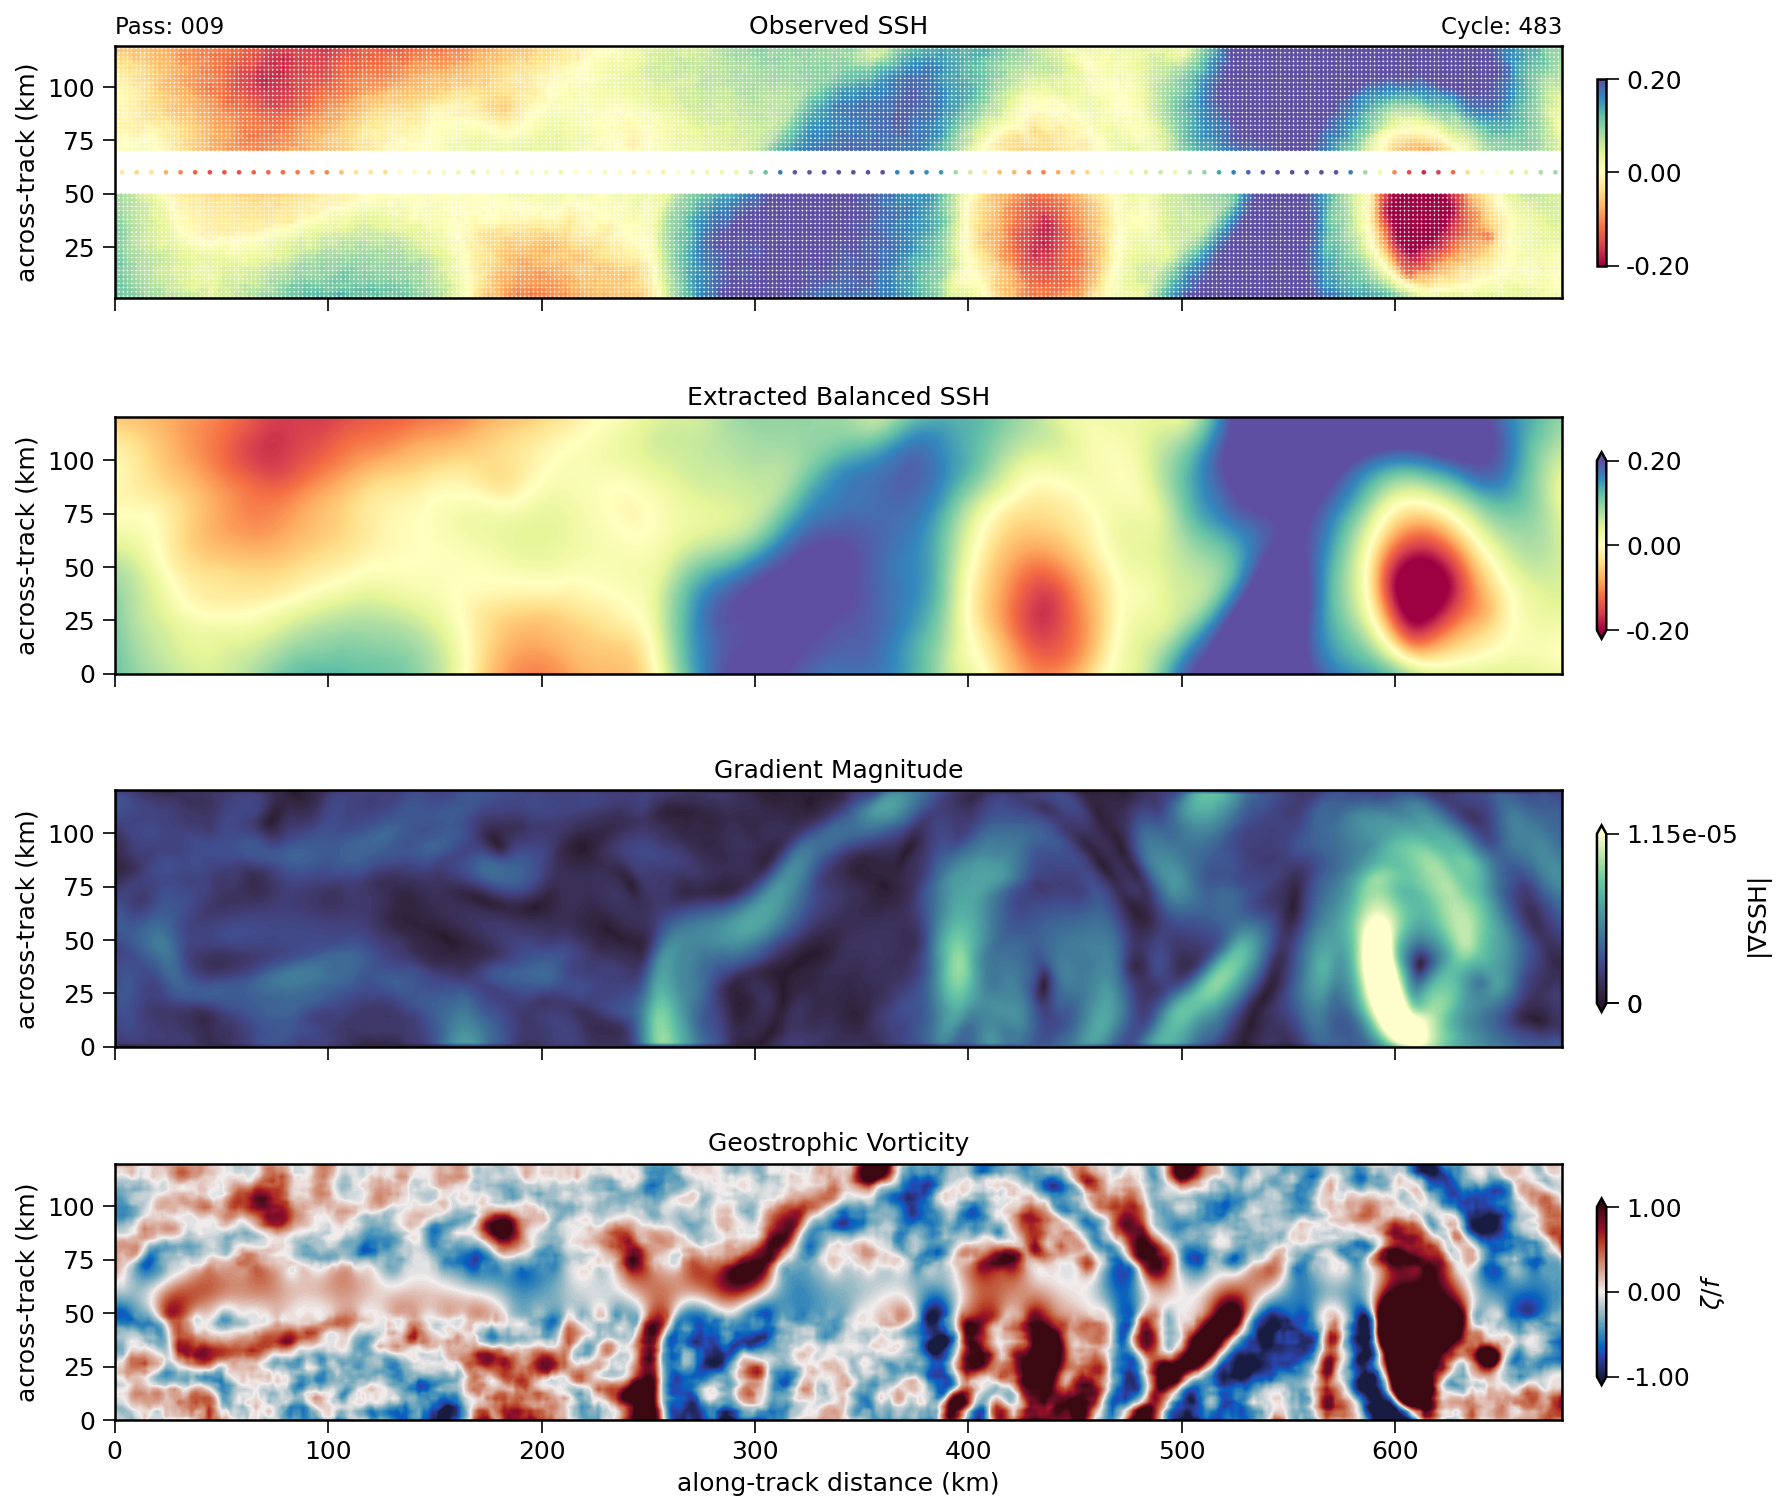

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import importlib
importlib.reload(swot)

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt).T  # shape: (nxt, nyt) -> [y,x]
vmin, vmax = -0.20, 0.20

# Axes coordinates in km (x = along-track, y = across-track)
x_km = np.linspace(0, nyt * karin.dx * 1e-3, ht_map.shape[1])  # columns
y_km = np.linspace(0, nxt * karin.dy * 1e-3, ht_map.shape[0])  # rows
XX, YY = np.meshgrid(x_km, y_km)

# ── figure with adjusted size for equal aspect
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True,
                         gridspec_kw={"hspace": 0.4})

# Get the original data for scatter plot - don't use the processed versions
karin_data = karin.ssha[index]
nadir_data = nadir.ssh[index]

# Create coordinate meshgrids if needed
if len(karin.x_grid.shape) == 1:
    x_grid_k, y_grid_k = np.meshgrid(karin.x_grid, karin.y_grid)
else:
    x_grid_k = karin.x_grid
    y_grid_k = karin.y_grid

# Apply masks and get valid data
mask_k_2d = np.isfinite(karin_data)
mask_n_1d = np.isfinite(nadir_data)

# KaRIn scatter
x_k_valid = x_grid_k[mask_k_2d].flatten()
y_k_valid = y_grid_k[mask_k_2d].flatten()
ssh_k_valid = karin_data[mask_k_2d].flatten()

# Nadir scatter
if len(nadir.x_grid.shape) == 1:
    x_n_valid = nadir.x_grid[mask_n_1d]
    y_n_valid = nadir.y_grid[mask_n_1d]
else:
    x_n_valid = nadir.x_grid.flatten()[mask_n_1d.flatten()]
    y_n_valid = nadir.y_grid.flatten()[mask_n_1d.flatten()]
ssh_n_valid = nadir_data[mask_n_1d]

# ── Panel 0: Observed SSH (scatter)
sc1 = axes[0].scatter(
    y_k_valid * 1e-3, x_k_valid * 1e-3,  # across (y) vs along (x)
    c=ssh_k_valid, s=5, cmap='Spectral',
    vmin=vmin, vmax=vmax, edgecolor="none"
)
# overlay nadir with same scale
axes[0].scatter(
    y_n_valid * 1e-3, x_n_valid * 1e-3,
    c=ssh_n_valid, s=5, cmap='Spectral',
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0].set_title("Observed SSH")
axes[0].set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
axes[0].set_title(f"Pass: {pass_number:03d}", fontsize=11, loc='left')
axes[0].set_ylabel("across-track (km)")
axes[0].margins(x=0, y=0) 
axes[0].set_aspect("equal")  # Equal aspect ratio
cbar0 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)
cbar0.set_ticks([vmin, 0, vmax])
cbar0.set_ticklabels([f'{vmin:.2f}', '0.00', f'{vmax:.2f}'])

# ── Diagnostics
lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), ht_map.shape[0])
geo_vort = swot.compute_geostrophic_vorticity_5pt(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
grad_mag = swot.compute_gradient_magnitude_5point(ht_map)

# Ensure each panel's color scale includes 0 so the middle tick is meaningful
ssh_levels  = np.linspace(vmin, vmax, 400)

# Gradient: force vmin to include 0 for the 0-tick
grad_data_min = float(np.nanmin(grad_mag))
grad_data_max = 0.8*float(np.nanmax(grad_mag))
grad_vmin = min(0.0, grad_data_min)
grad_vmax = 0.9* grad_data_max
grad_levels = np.linspace(grad_vmin, grad_vmax, 100)

# Vorticity: choose symmetric limits around 0 (you had these already)
vort_vmin, vort_vmax = -1.0, 1.0
vort_levels = np.linspace(vort_vmin, vort_vmax, 100)

# ── Panel 1: Extracted Balanced SSH (contourf)
cf0 = axes[1].contourf(XX, YY, ht_map, levels=ssh_levels, cmap='Spectral', extend='both')
axes[1].set_title("Extracted Balanced SSH")
axes[1].set_ylabel("across-track (km)")
axes[1].set_aspect("equal")
cbar1 = fig.colorbar(cf0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)
cbar1.set_ticks([vmin, 0, vmax])
cbar1.set_ticklabels([f'{vmin:.2f}', '0.00', f'{vmax:.2f}'])

# ── Panel 2: Gradient magnitude (contourf) — three ticks: min, 0, max
cf1 = axes[2].contourf(XX, YY, grad_mag, levels=grad_levels, cmap='cmo.deep_r', extend='both')
axes[2].set_title("Gradient Magnitude")
axes[2].set_ylabel("across-track (km)")
axes[2].set_aspect("equal")
cbar2 = fig.colorbar(cf1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02)
cbar2.set_ticks([grad_vmin, 0, grad_vmax])
cbar2.set_ticklabels([f'{grad_vmin:.2e}', '0', f'{grad_vmax:.2e}'])
cbar2.set_label(r'$|\nabla \mathrm{SSH}|$')

# ── Panel 3: Geostrophic Vorticity (contourf) — three ticks: min, 0, max
cf2 = axes[3].contourf(XX, YY, geo_vort, levels=vort_levels, cmap=cmocean.cm.balance, extend='both')
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
axes[3].set_aspect("equal")
cbar3 = fig.colorbar(cf2, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02)
cbar3.set_ticks([vort_vmin, 0, vort_vmax])
cbar3.set_ticklabels([f'{vort_vmin:.2f}', '0.00', f'{vort_vmax:.2f}'])
cbar3.set_label(r'$\zeta / f$')

#plt.tight_layout()
plt.savefig("balanced_extraction.png", dpi=300, bbox_inches="tight")
plt.show()

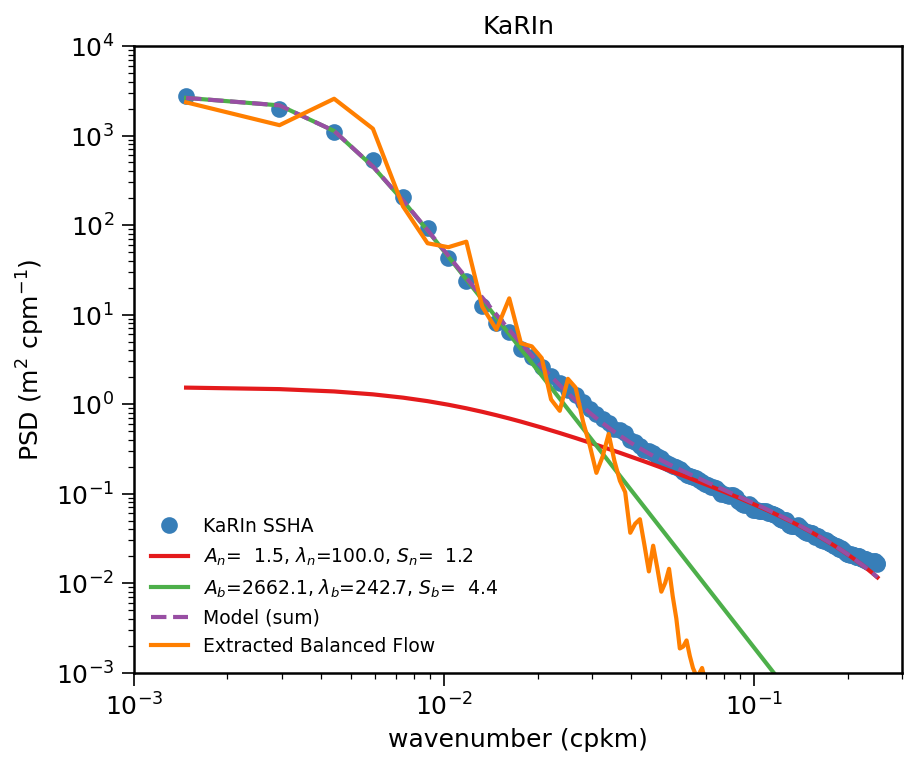

In [35]:
def plot_spectrum_comparison(karin_obj, swot_obj, poptcwg_karin_params, ht_map_2d):
    
    # Extract KaRIn wavenumbers and sample mean spectrum
    k_karin = karin_obj.wavenumbers[int(karin_obj.track_length/2):]
    karin_spec_sample_mean = karin_obj.spec_alongtrack_av[int(karin_obj.track_length/2):]

    # Ensure consistent slicing for model inputs (skipping the first wavenumber)
    k_karin_sliced = k_karin[1:]

    # Put the wavenumbers through the models to get the functional form
    spbalanced = swot_obj.balanced_model(k_karin_sliced, *poptcwg_karin_params[0:3])
    spunbalanced = swot_obj.unbalanced_model(k_karin_sliced, *poptcwg_karin_params[3:7])

    nx_dim = ht_map_2d.shape[1] # Along-track dimension
    ny_dim = ht_map_2d.shape[0] # Across-track dimension 
    ht_map_coords = {
        'pixel': np.arange(0, ny_dim) * karin_obj.dy, # Across-track coordinate
        'line': np.arange(0, nx_dim) * karin_obj.dx   # Along-track coordinate
    }
    ht_map_xr = xr.DataArray(ht_map_2d, coords=ht_map_coords, dims=['pixel', 'line'])
    spec_ht_map_2s = swot_obj.mean_power_spectrum(ht_map_xr, karin_obj.window, 'line', ['pixel'])
    spec_ht_map = spec_ht_map_2s[int(karin_obj.track_length/2):][1:]

    # --- Plotting ---
    fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=150, constrained_layout=True)
    k_km = k_karin_sliced * 1e3
    axs.loglog(k_km, karin_spec_sample_mean[1:], 'o', label='KaRIn SSHA')
    axs.loglog(k_km, spunbalanced,
                  label=r'$A_n$=%5.1f, $\lambda_n$=%5.1f, $S_n$=%5.1f' %
                  (poptcwg_karin_params[3], 100, poptcwg_karin_params[5]))
    axs.loglog(k_km, spbalanced,
                  label=r'$A_b$=%5.1f, $\lambda_b$=%5.1f, $S_b$=%5.1f' %
                  (poptcwg_karin_params[0], poptcwg_karin_params[1]*1e-3, poptcwg_karin_params[2]))
    axs.loglog(k_km, (spunbalanced + spbalanced), '--', label='Model (sum)')
    axs.loglog(k_km, spec_ht_map, '-', lw=2, label='Extracted Balanced Flow')
    axs.set_xlabel('wavenumber (cpkm)')
    axs.set_ylabel('PSD (m$^2$ cpm$^{-1}$)')
    axs.set_xlim(1e-3, 3e-1)
    axs.set_ylim(1e-3, 1e4)
    axs.set_title('KaRIn')
    axs.legend(loc='lower left', frameon=False, fontsize=9)

    plt.show()


plot_spectrum_comparison(
        karin_obj=karin,
        swot_obj=swot,
        poptcwg_karin_params=poptcwg_karin,
        ht_map_2d=ht_map
    )

### 6. Compare Nadir Vs No-Nadir 

In [ ]:
# ---- mask KaRIn observations ----
mask_k = np.isfinite(karin.ssha[index])

# ensure 2D coordinate arrays to mask consistently
if karin.x_grid.ndim == 1 and karin.y_grid.ndim == 1:
    Xk, Yk = np.meshgrid(karin.x_grid, karin.y_grid)  # [ny, nx]
else:
    Xk, Yk = karin.x_grid, karin.y_grid               # already 2D

# observed coords and values (1D)
xk_obs = Xk[mask_k].ravel()
yk_obs = Yk[mask_k].ravel()
h_obs  = karin.ssha[index][mask_k].ravel()

# ---- covariances on observed points ----
# signal covariance among observed KaRIn points
C_obs = swot.build_covariance_matrix(c, xk_obs, yk_obs)

# KaRIn noise covariance among observed points (correlated)
dx = xk_obs[:, None] - xk_obs[None, :]
dy = yk_obs[:, None] - yk_obs[None, :]
N_obs = nk(np.hypot(dx, dy))

# ---- target grid and estimation ----
xt, yt, nxt, nyt = swot.make_target_grid(karin, extend=False)

ht_karonly = swot.estimate_signal_on_target(
    c, xt, yt, xk_obs, yk_obs, C_obs, N_obs, h_obs
)

# match your usual [y, x] plotting convention
ht_karonly_map = ht_karonly.reshape(nyt, nxt).T


Calculating covariance matrices...
Estimating signal on target points...


ValueError: operands could not be broadcast together with shapes (60,339) (339,60) 

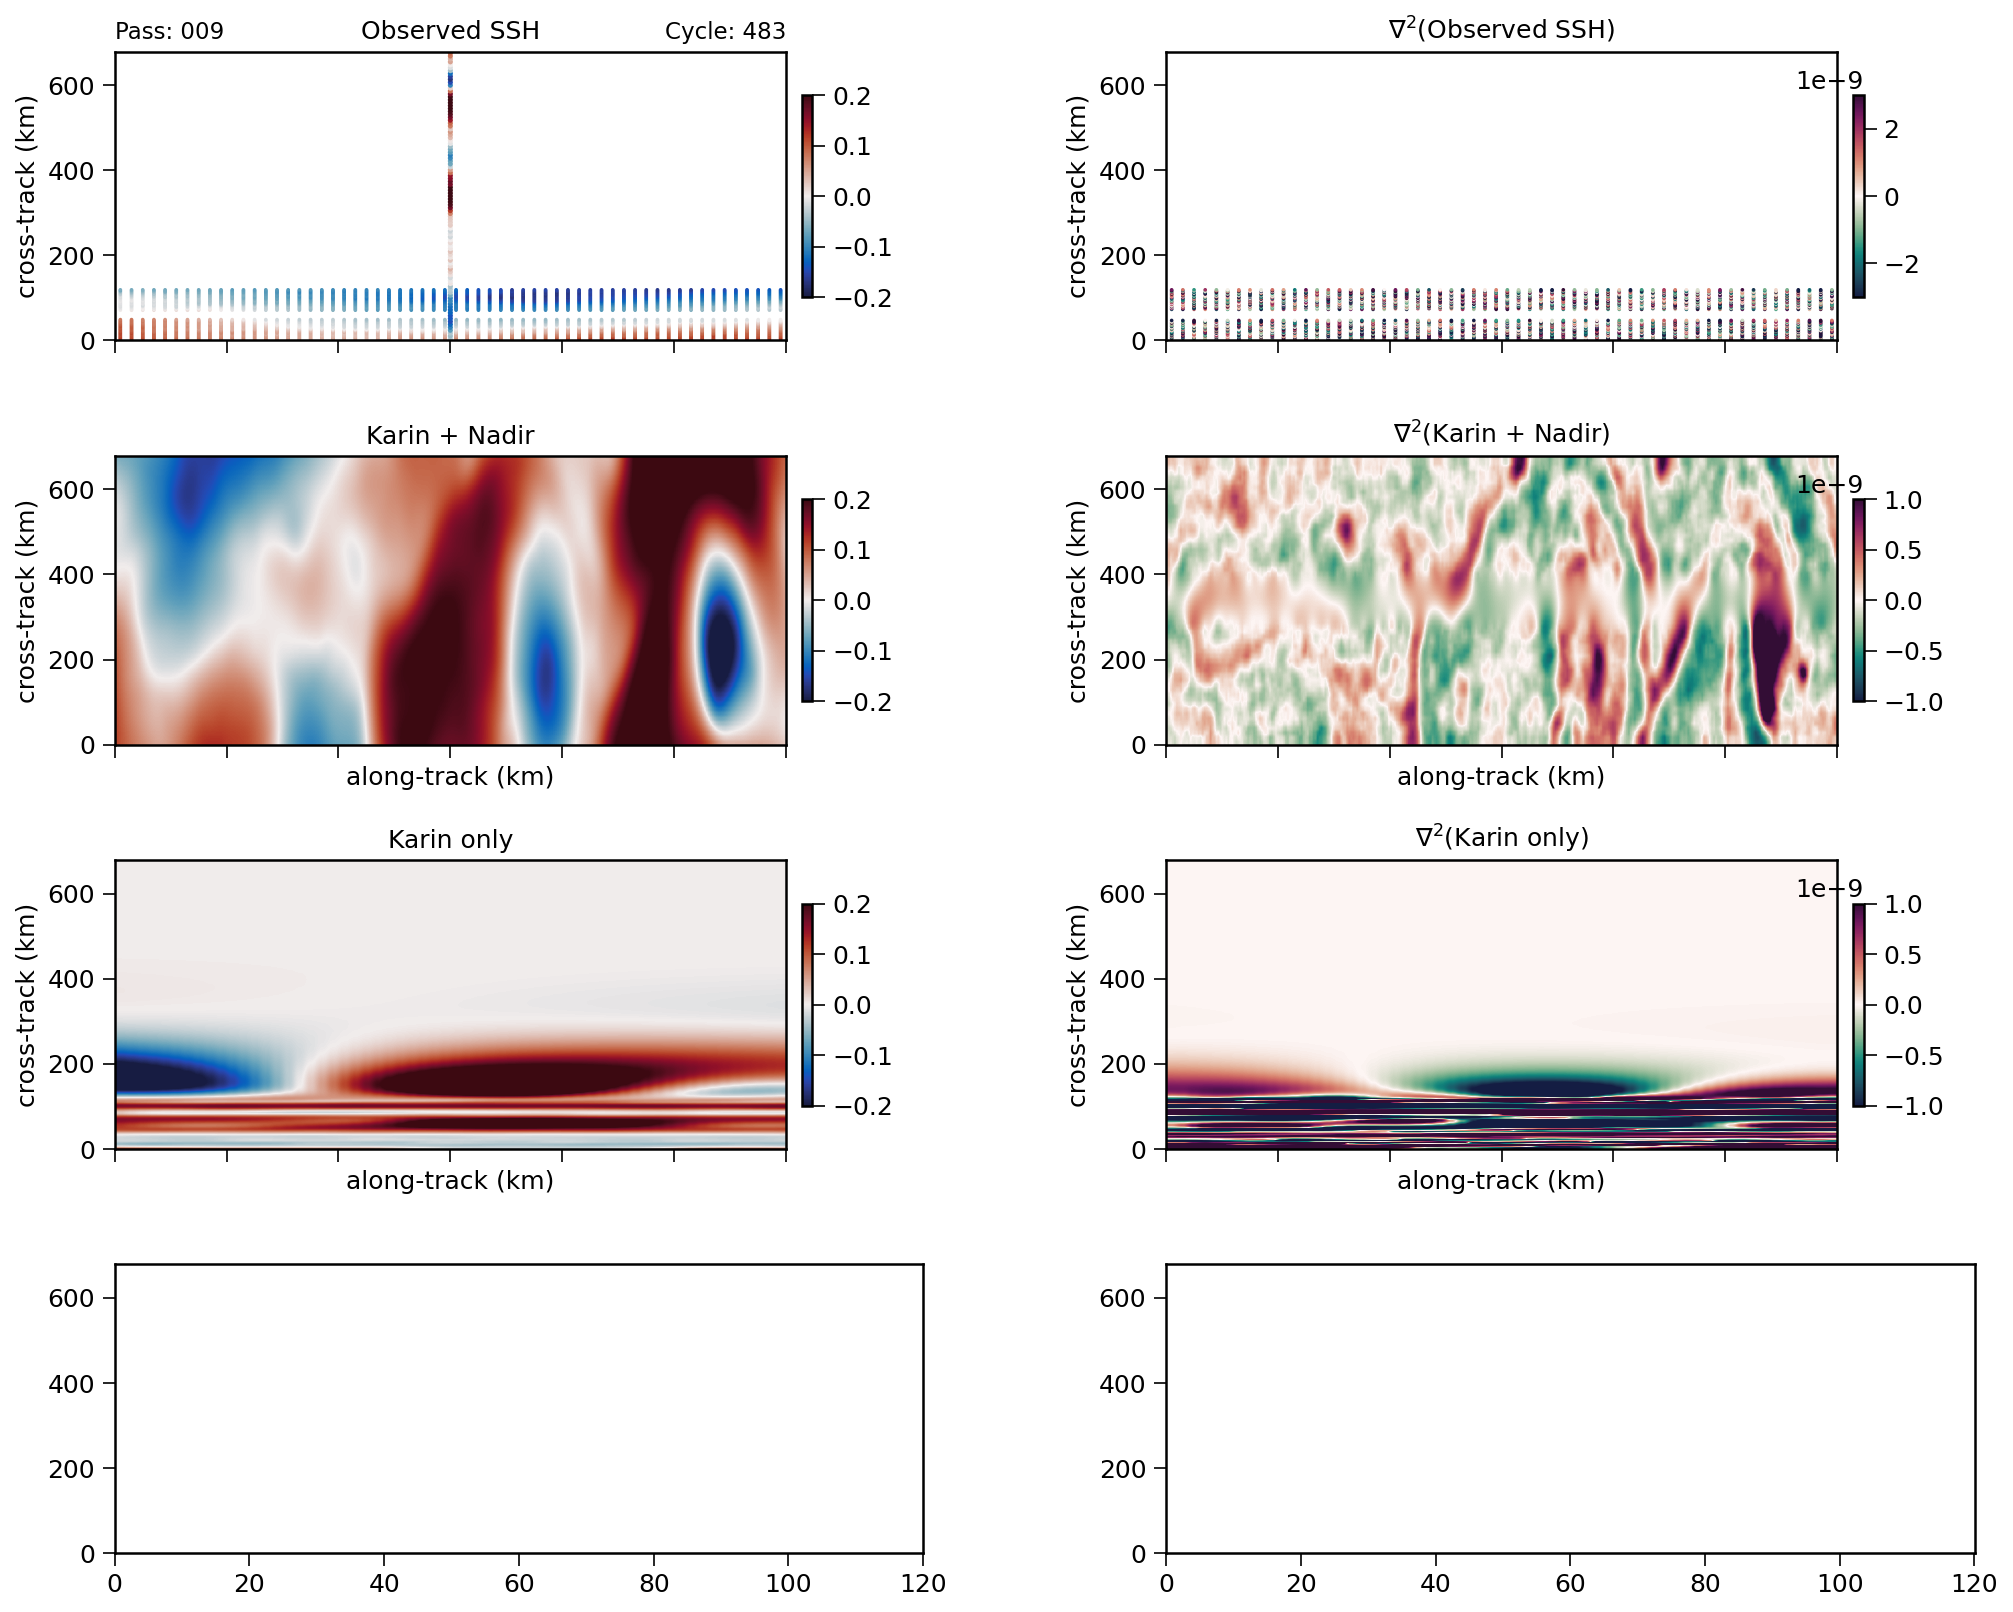

In [32]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [18]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "ENA"
run_dir = f"./outputs/{name}_P{pass_number:03d}"
os.makedirs(run_dir, exist_ok=True)

# Final filter on the data based on how many NaNs are in the strip
max_nan_frac = 0.3  # if >30% of nadir points are NaN, skip the frame
bad_cycles_nan_frac = []  # Tracks KaRIn strips failing NaN fraction threshold

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        # Build masks
        mask_k = ~np.isnan(karin.ssha[index])
        mask_n = ~np.isnan(nadir.ssh[index])

        # check KaRIn NaN fraction
        nan_frac = 1.0 - (mask_k.sum() / mask_k.size)
        print(nan_frac)
        if nan_frac > max_nan_frac:
            bad_cycles_nan_frac.append(cycle[index])
            print(f"Skipping Frame {index:03d}: {nan_frac:.0%} NaNs in KaRIn exceeds {max_nan_frac:.0%}")
            return None
        
        # Obs values
        h_obs = np.concatenate((
            karin.ssha[index][mask_k].flatten(order="C"),
            nadir.ssh[index][mask_n]
        ))
        
        # Obs grids
        xkk = karin.x_grid[mask_k].flatten(order="C")
        ykk = karin.y_grid[mask_k].flatten(order="C")
        xnn = nadir.x_coord[mask_n]
        ynn = nadir.y_coord[mask_n]
        
        xobs = np.concatenate((xkk, xnn))
        yobs = np.concatenate((ykk, ynn))
        
        # Build covariance matrix
        C_obs = swot.build_covariance_matrix(c, xobs, yobs)
        
        # Build noise matrices
        Nk_obs = nk(np.hypot(
            xobs[:len(xkk), None] - xobs[:len(xkk)],
            yobs[:len(xkk), None] - yobs[:len(xkk)]
        ))
        
        Nn_obs = sigma**2 * np.eye(len(xnn))
        N_obs = block_diag(Nk_obs, Nn_obs)
        
        # target grid
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        ht = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs)
        ht_map = ht.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin.dx, karin.dy, lats)

        basename = f"P{pass_number:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht.reshape(nyt, nxt))
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        plots_dir = os.path.join(run_dir, "plots")
        
        swot.plot_ssh_summary(ht, nyt, nxt,
                     ykk, xkk, mask_k,
                     ynn, xnn, mask_n,
                     karin, nadir,
                     index,
                     shared_cycles,
                     pass_number,
                     swot, 
                     plots_dir, 
                     basename)
          
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Run in parallel ----
n_frames = karin.ssha.shape[0]
results = Parallel(n_jobs=4, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)

# ---- Save the karin and nadir classes ----
# save these so we have all the parameters if we need them later (e.g., lats, lons etc.)
karin.bad_cycles_nan_frac = bad_cycles_nan_frac # keep track of the cycles we discarded
with open(os.path.join(run_dir, f'karin_class_P{pass_number:03d}.pkl'), 'wb') as f:
    pickle.dump(karin, f)
with open(os.path.join(run_dir, f'nadir_class_P{pass_number:03d}.pkl'), 'wb') as f:
    pickle.dump(nadir, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/plot_tools.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/plot_tools.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/plot_tools.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/plot_tools.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/plot_tools.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layo

Saved karin and nadir class objects to './outputs/ENA_P005/'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt)
vmin, vmax = np.nanpercentile(ht_map, [2, 98])   # robust limits

# ── build the figure
fig, axes = plt.subplots(4, 1, figsize=(10, 13), sharex=True,
                         gridspec_kw={"hspace": 0.4})

sc = axes[0].scatter(
    karin.y_grid * 1e-3, karin.x_grid * 1e-3,
    c=karin.ssha[index, :, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
sc = axes[0].scatter(
    xn * 1e-3, yn * 1e-3,
    c=nadir.ssh[index, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0].set_title("Observed SSH")
axes[0].set_title("Cycle: {}".format(shared_cycles[index]), fontsize=11, loc='right')
axes[0].set_title("Pass: {:03d}".format(pass_number), fontsize=11, loc='left')
#axes[0].set_xlabel("along-track (km)")
axes[0].set_ylabel("across-track (km)")
axes[0].set_aspect("auto")
fig.colorbar(sc, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)

lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), 64)
print(lats.shape)
geo_vort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)


# 1. gridded estimate (imshow)
im0 = axes[1].imshow(
    ht_map,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax
)
axes[1].set_title("Generated SSH")
axes[1].set_ylabel("across-track (km)")
fig.colorbar(im0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)

im1 = axes[2].imshow(
    swot.compute_gradient(ht_map),
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.deep_r
)
axes[2].set_title("Gradient")
axes[2].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\nabla(SSH)$')

im1 = axes[3].imshow(
    geo_vort,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    vmin = -1, 
    vmax = 1,
    cmap=cmocean.cm.balance
)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\zeta / f$')

# shared colour-bar
plt.tight_layout()
plt.show()


### PDF of Cyclonicity

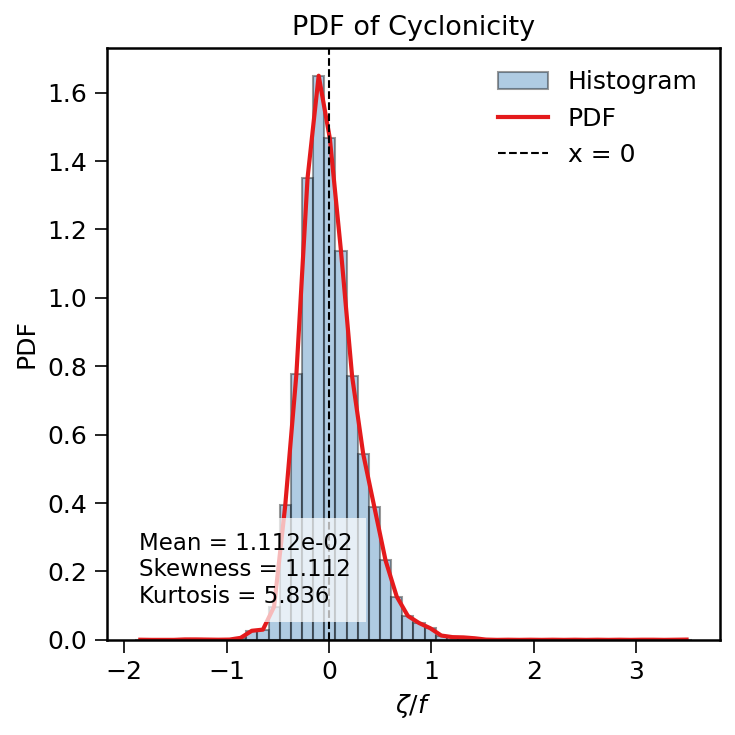

In [31]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = geo_vort.ravel()
vals = vals[~np.isnan(vals)]

mean_vort = np.mean(vals)
skew_vort = stats.skew(vals, bias=False)
kurt = kurtosis(vals, fisher=True, bias=False)

# 4. Build histogram (density) and get bin‐centers
n_bins = 50
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

# 5. Plot
plt.figure(figsize=(5, 5))

# filled histogram
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

# line through the PDF
plt.plot(centers, hist, '-', lw=2, label='PDF')

# annotate mean & skewness
txt = (
    f"Mean = {mean_vort:.3e}\n"
    f"Skewness = {skew_vort:.3f}\n"
    f"Kurtosis = {kurt:.3f}"
)
at = AnchoredText(txt, loc='lower left', prop=dict(size=11), frameon=True, pad=0.6, borderpad=0.8)
at.patch.set(alpha=0.7, facecolor='white', edgecolor='none')
plt.gca().add_artist(at)

plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Compare interpolation with Nadir to without Nadir 

In [ ]:
index = 1 

# observed ssha values
h_karin = karin.ssha[index].T.flatten(order="C")[mask_k_flat]

# Karin noise and signal on observed pixels
N_obs  = nk(np.hypot(
                    xk[:mask_k_flat.sum(), None] - xk[:mask_k_flat.sum()],
                    yk[:mask_k_flat.sum(), None] - yk[:mask_k_flat.sum()]))

C_obs = swot.build_covariance_matrix(c,  xk, yk)

ht_karonly = swot.estimate_signal_on_target(c, xt, yt, xk, yk, C_obs, N_obs, h_karin)
ht_karonly_map = ht_karonly.reshape(nyt, nxt)

Calculating covariance matrices...
Estimating signal on target points...


#Check this part because the lap difference doesnt match what visual inspection of the differences suggests

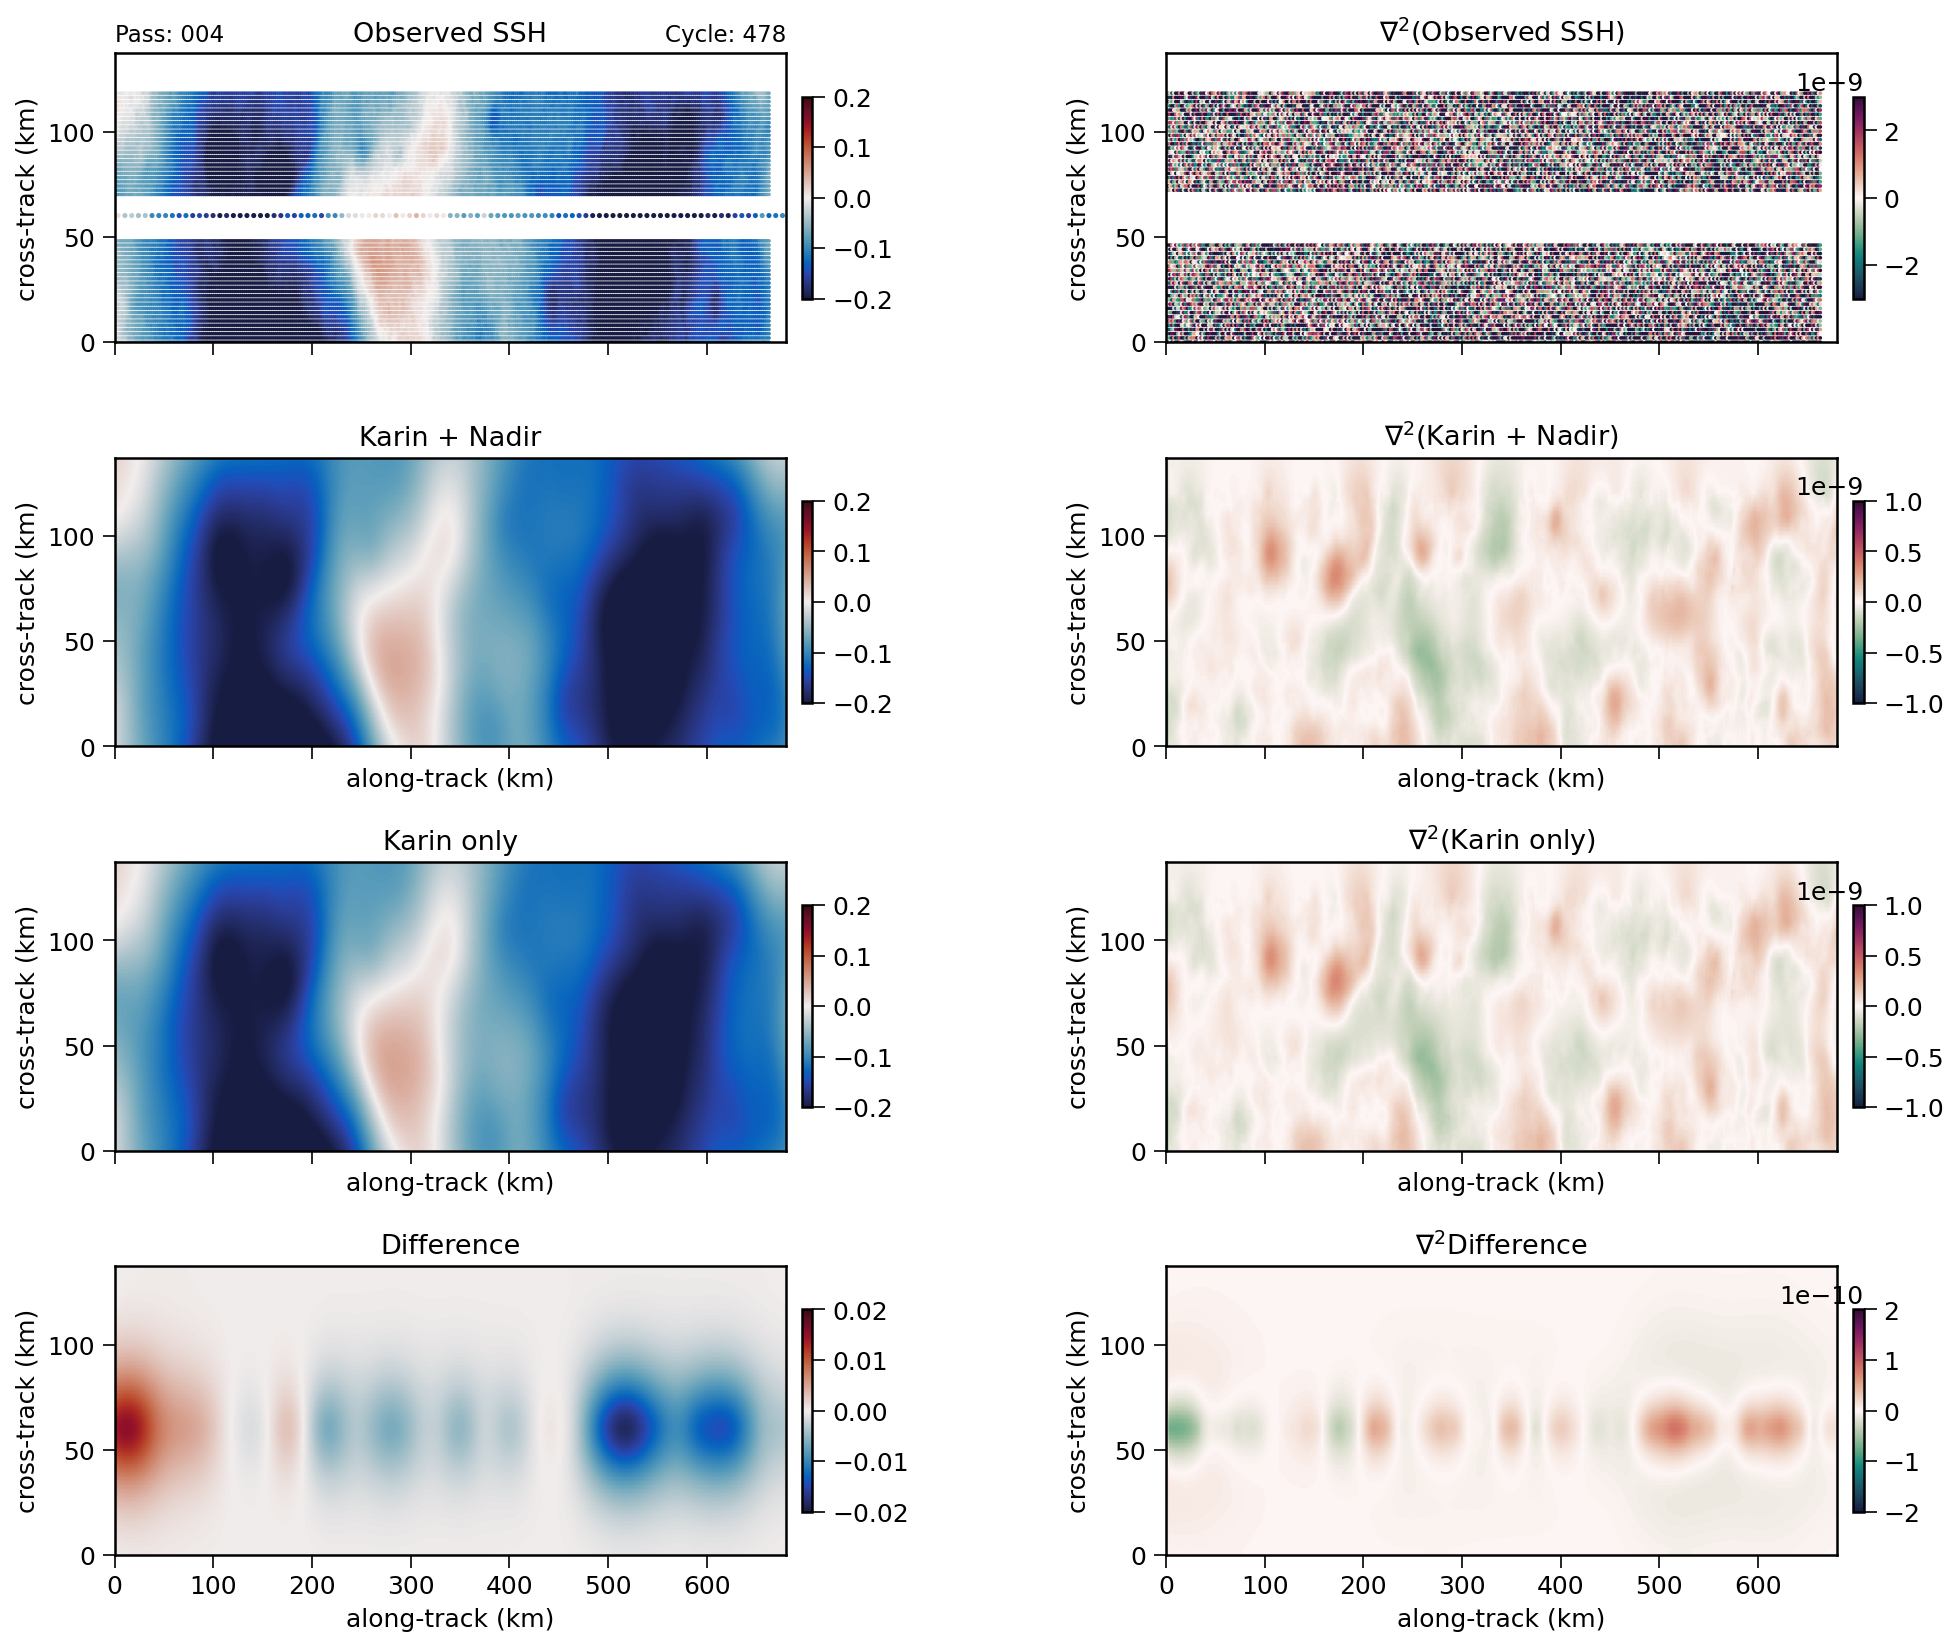

In [46]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define your per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)



In [53]:
# Spectra of nadir vs no nadir 

# y_coord  = dy_karin * np.arange(track_length)            # m along track
# x_coord  = dx_karin * np.arange(total_width)             # m across track

gen_sample_mean = compute_gen_sample_mean(ht_map, karin.x_coord, karin.y_coord) # here the x y is our track dims from above not xobs yobs
gen_sample_mean_karonly = compute_gen_sample_mean(ht_karonly_map, x, y)

# plot the weighted fit
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_km[1:], spectrum_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spbalanced,label = r'Balanced:$\sigma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced:$\sigma$=%5.3f, $\gamma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[2:5]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], gen_sample_mean[1:],'-', label = 'Karin + Nadir')
plt.loglog(k_km[1:], gen_sample_mean_karonly[1:],'--b', label = 'Karin only')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
#plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit karin data')

ValueError: conflicting sizes for dimension 'pixel': length 70 on the data but length 60 on coordinate 'pixel'

In [55]:
print(ht_map.shape)
print(karin.ssha.shape)

(70, 339)
(97, 339, 60)


## Experiments 

In [ ]:
# Experimenting with building the grid from the data lats and lons

from scipy.linalg import block_diag

index = 5 # time index 

mask_k = ~np.isnan(karin.ssha[index])
mask_n = ~np.isnan(nadir.ssh[index]) # N.B we are using SSH here because we aren't subtracting the time mean from the nadir

#  masks for karin and nadir
mask_k_flat = mask_k.T.flatten(order="C")             # transpose to match meshgrid order
mask_full   = np.concatenate((mask_k_flat, mask_n))   # len = nx*ny + nn

# Now we build our observation points from the data grid directly
xk, yk, xt, yt = swot.make_karin_points_from_data(karin, index) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, index) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# observed ssha values
h_obs = np.concatenate((
    karin.ssha[index].T.flatten(order="C")[mask_k_flat],   # Karin
    nadir.ssh[index][mask_n]                               # Nadir
))

# covariance for observed points
C_obs = swot.build_covariance_matrix(c,  xobs, yobs) # we already built this above
#C_obs = C

# Karin noise block on observed pixels
Nk_obs  = nk(np.hypot(
                    xobs[:mask_k_flat.sum(), None] - xobs[:mask_k_flat.sum()],
                    yobs[:mask_k_flat.sum(), None] - yobs[:mask_k_flat.sum()]))

# Nadir noise block (white noise on diagonal)
Nn_obs  = sigma**2 * np.eye(mask_n.sum())

# assemble block-diagonal noise matrix
N_obs = block_diag(Nk_obs, Nn_obs)

# solve on the reduced system 
#xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True) # make our target grid with the gap filled
ht = swot.estimate_signal_on_target(c, xt.T.flatten(order="C"), yt.T.flatten(order="C"), xobs, yobs, C_obs, N_obs, h_obs)

xk, yk, xt, yt = swot.make_karin_points_from_data(karin, 1) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, 1) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

print(xobs.shape)
print(N_obs.shape)
print(Nk_obs.shape)
print(Nn_obs.shape)
print(mask_k.shape)
print(mask_n.shape)
print(xt.shape)

plt.figure(figsize=(8, 6))
plt.scatter(xobs.flatten(), yobs.flatten(), c = karin.ssha[index].T.flatten(order="C"), label='Observed', s=1)
plt.scatter(xt.flatten(), yt.flatten(), marker = 'x', s=1, label='Target')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Observed vs Target Points')
plt.legend()
plt.tight_layout()
plt.show()